# Trotter + Finite difference approach to the KvN problem

Here we will try to solve the nonlinear ODE 

$\frac{\partial x}{\partial t} = -x^2,$ with $x(0)=1$

using finite differences and Trotter formula

### Forwards difference attempt

In [1]:
import KvN_tools as kvn
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
# Set up the grid
n_qubits = 10
n_grid = 2**n_qubits
grid_extent = (0,2)
x = np.linspace(*grid_extent, n_grid)

# Set up time
n_steps = 1500
delta = 0.001
t = np.linspace(0, n_steps*delta, n_steps)
print(len(t))

1500


In [3]:
# Define finite (forwards) difference momentum operator
def P(x): 
  dx = x[1] - x[0]
  matrix = - np.diag(np.ones(len(x), dtype=complex)) + np.diag(np.ones(len(x)-1), k=1)
  return -1.0j*matrix/dx

# Define the X operator
def X(x):
  X = np.diag(x)
  return X@X

# Assemble Trotter formula 
def Trotter(x, n, t):
  # Calculate H1
  H1 = 0.5*P(x)@X(x)
  H2 = 0.5*X(x)@P(x)

  # Calculate the time evolution operator
  exp1 = scipy.linalg.expm(-1.0j*H1*t/n)
  exp2 = scipy.linalg.expm(-1.0j*H2*t/n)

  U = (exp1@exp2)**n

  U_approx = (np.eye(len(x)) + (-1.0j*H1*t + -1.0j*H2*t)/n)**n

  return U, U_approx

In [4]:
# Calculate the time evolution operator
U, U_approx = Trotter(x, 100, delta)

# Set up the initial state (delta in this case)
psi = kvn.psi0(x, 1)

psi_store = np.zeros((n_grid, n_steps), dtype=complex)

# Evolve the state
for i in range(n_steps):
  psi = U_approx@psi
  
  if np.isnan(psi).any():
    print("NaN encountered at step", i)
    break

  psi_store[:,i] = psi

psi_store = psi_store[:, :i]
t = t[:i]

if np.isnan(psi_store).any():
  print('Residual NaN in psi')


Initializing the state
NaN encountered at step 1393


/home/matt/PhD/Sketch work/PhD-Work/Linearisation/KvN/KvN_tools.py:139: RuntimeWarning: overflow encountered in square
  rho_store = np.abs(psi_store)**2


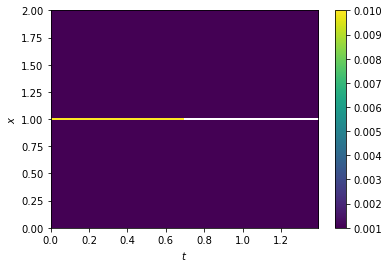

In [5]:
# Plot the results

kvn.plot_evolution(x, psi_store, t)


### Central difference attempt

Initializing the state
Generating the Hamiltonian
Exponetiating the Hamiltonian
Time evolution


100%|██████████| 1499/1499 [00:02<00:00, 711.33it/s]


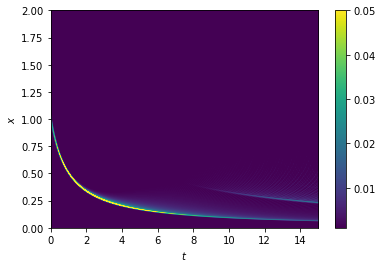

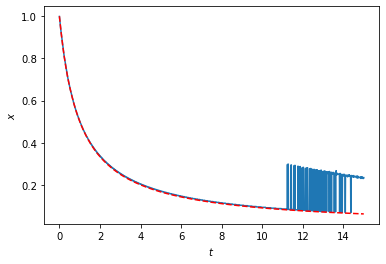

In [25]:
# Quadratic parameters
params = (-1,0,0)

# Set up the grid
n_qubits = 10
n_grid = 2**n_qubits
grid_extent = (0,2)
x = np.linspace(*grid_extent, n_grid)

x0 = 1

# Set up time
n_steps = 1500
delta = 0.01
t = np.linspace(0, n_steps*delta, n_steps)

# Initial state
psi = kvn.psi0(x, x0, type='gaussian')

# Define finite (forwards) difference momentum operator
def P(x): 
  dx = x[1] - x[0]
  matrix = - np.diag(np.ones(len(x)-1), k=-1) + np.diag(np.ones(len(x)-1), k=1)
  return -1.0j*matrix/(2*dx)

# Define the X operator
def F(x, params):
  a, b, c = params
  X = np.diag(x)
  return a*X@X + b*X + c*np.eye(len(x))

def hamiltonian_vec(x, psi, params):
    return 0.5*(P(x)@F(x, params)@psi + F(x, params)@P(x)@psi)  # Return the Hamiltonian

def KvN_hamiltonian_vec(x, params):
    print('Generating the Hamiltonian')
    n = len(x)
    H = np.zeros((n, n), dtype=complex)

    #for i in tqdm(range(n)):
    #    psi_i = np.zeros(n)
    #    psi_i[i] = 1
    #    H[:, i] = hamiltonian(x, psi_i, params)

    psi_i = np.eye(n)
    H = hamiltonian_vec(x, psi_i, params)

    return H

H = KvN_hamiltonian_vec(x, params)


psi_store = kvn.time_evolution(H, psi, delta, n_steps)
kvn.plot_evolution(x, psi_store, t, save=True,  vmax=0.05)
kvn.plot_mode(x, psi_store, t, plot_analytical=True, params=params, save=False, x0=x0)